In [22]:
# Standard libraries
import numpy as np
import json
from datetime import datetime

# Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_ibm_provider import IBMProvider

# Own library
from quantum_gates.simulators import MrAndersonSimulator
from quantum_gates.gates import standard_gates
from quantum_gates.circuits import EfficientCircuit, AlternativeCircuit, Circuit
from quantum_gates.utilities import DeviceParameters
from quantum_gates.utilities import setup_backend



In [31]:
file_path = "/Users/paolodarold/Desktop/Internship/QISKIT_TOKEN.txt"

try:
    with open(file_path, "r") as file:
        content = file.read()  # Read the entire content of the file as a string
except FileNotFoundError:
    print(f"File '{file_path}' not found.")

content = content[:-2]

IBM_TOKEN = content

In [ ]:
provider = IBMProvider(token=IBM_TOKEN)
backend = provider.get_backend('ibm_brisbane')
prop = backend.properties()

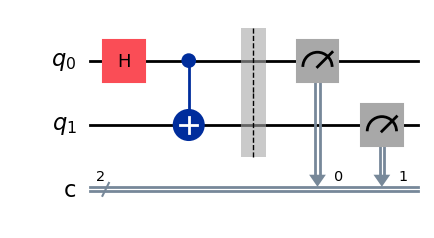

In [7]:
N_QUBIT = 2
N_BIT = 2

circ = QuantumCircuit(N_QUBIT,N_BIT)

"""
circ.rz(-np.pi, 0)
circ.rz(-np.pi/2, 1)

circ.sx(0)
circ.sx(1)

circ.rz(-np.pi, 1)


circ.rz(-np.pi/2,0)
circ.rz(np.pi/2,1)

circ.sx(0)
circ.sx(1)

circ.rz(np.pi/2,0)
circ.rz(np.pi/2,1)
"""

circ.h(0)
circ.cx(0,1)




circ.barrier(range(N_QUBIT))
circ.measure(range(N_QUBIT),range(N_QUBIT))
circ.draw('mpl')

In [8]:
config = {
    "backend": {
        "hub": "ibm-q",
        "group": "open",
        "project": "main",
        "device_name": "ibmq_manila"
    },
    "run": {
        "shots": 1000,
        "qubits_layout": [0,1],
        "psi0": [1, 0, 0, 0]
    }
}

run_config = config["run"]
qubits_layout = run_config["qubits_layout"]
print(qubits_layout)

device_param = DeviceParameters(qubits_layout)
device_param.load_from_backend(backend)
device_param_lookup = device_param.__dict__()

[0, 1]


In [9]:
sim = MrAndersonSimulator(gates=standard_gates, CircuitClass=EfficientCircuit)

t_circ = transpile(
    circ,
    backend,
    scheduling_method='asap',
    initial_layout=qubits_layout,
    seed_transpiler=42
)

#t_circ.draw(output='mpl')

We only support a linear connectivity at the moment.


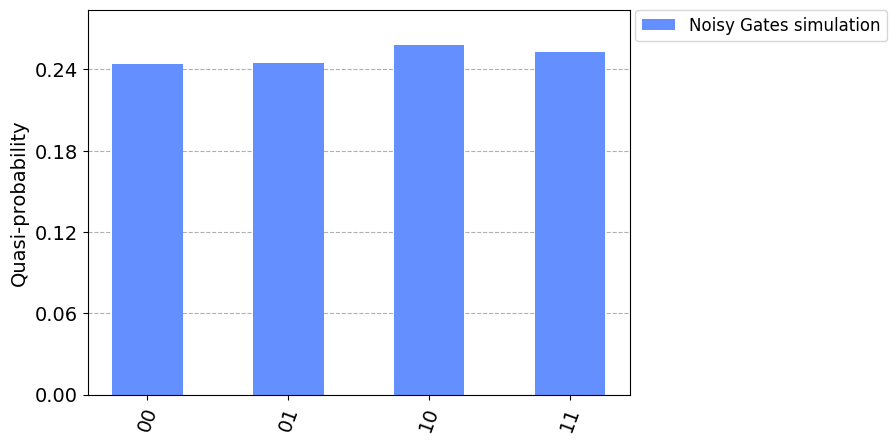

In [10]:
probs = sim.run(
    t_qiskit_circ=t_circ, 
    qubits_layout=qubits_layout, 
    psi0=np.array(run_config["psi0"]), 
    shots=run_config["shots"], 
    device_param=device_param_lookup,
    nqubit=N_QUBIT)

counts_ng = {format(i, 'b').zfill(2): probs[i] for i in range(0, 4)}

plot_histogram(counts_ng, bar_labels=False, legend=['Noisy Gates simulation'])

In [134]:
data

[CircuitInstruction(operation=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(127, 'q'), 0),), clbits=()),
 CircuitInstruction(operation=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(127, 'q'), 1),), clbits=()),
 CircuitInstruction(operation=Delay(duration=120[unit=dt]), qubits=(Qubit(QuantumRegister(127, 'q'), 2),), clbits=())]

In [128]:
swap_detector

[0, 1, 2]

In [135]:
prob = sim._perform_simulation(1000, data, n_rz, N_QUBIT, device_param_lookup, [0, 0, 0, 1])


In [136]:
prob

array([1.03026604e-02, 9.46388151e-01, 2.01420081e-04, 1.87941202e-02,
       2.78582162e-04, 2.36181319e-02, 5.54402383e-06, 4.54909427e-04])

In [137]:
reordered_probs = sim._fix_probabilities(prob, swap_detector, N_QUBIT)

In [138]:
reordered_probs

[0.010302660406997531,
 0.9463881509020848,
 0.00020142008123279749,
 0.01879412017825435,
 0.0002785821616969695,
 0.023618131894352908,
 5.54402382762438e-06,
 0.0004549094267076543]